In [1]:
import keras_genomics
from keras_genomics.layers.convolutional import RevCompConv1D
import keras
import keras.layers as kl
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from seqdataloader.batchproducers import coordbased
from seqdataloader.batchproducers.coordbased import coordstovals
from seqdataloader.batchproducers.coordbased import coordbatchproducers
from seqdataloader.batchproducers.coordbased import coordbatchtransformers
from keras.models import load_model
from keras.utils import CustomObjectScope
from deeplift.dinuc_shuffle import dinuc_shuffle
import pandas as pd
import json
import os
import gzip
from math import log
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr, gaussian_kde
%matplotlib inline

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

In [2]:
dfs = pd.read_excel("../data/experimental/gcPBM/GSE97793_Combined_ets1_100nM_elk1_100nM_50nM_gabpa_100nM_log.xlsx")

In [3]:
dfs.head()

,ID_REF,ID,Sequence,Ets1_100nM,Elk1_100nM,Elk1_50nM,Gabpa_100nM
0,1,Bound,TCGGCGGCGGAGCACCGGAAGTTCTGCAGCACTGGC,10.7065,10.7019,10.7916,11.4822
1,2,Bound,GTTTAGATAACTGACCGGATGATTACCCTCTCCATC,9.4762,8.8623,9.1490,8.7324
2,3,Bound,TGGACCTAGGGCAGACGGAAGTTTTGGGAGGGCCGG,9.5459,9.3227,9.6038,9.0362
3,4,Bound,ATCAAGGCGCGGCGGCGGAAAAATGTGAAATGGCTT,7.8294,8.7105,8.7679,8.8320
4,5,Bound,TCCTTACTCCGTGGCCGGAACTGGGTGCGCTCCTAC,9.7629,9.1093,9.5305,9.1809


In [4]:
dfs.tail()

,ID_REF,ID,Sequence,Ets1_100nM,Elk1_100nM,Elk1_50nM,Gabpa_100nM
13670,13671,NegCtrl,TTTGCCGACGGCGATGCCGCTGGGTGCTCATCTCAC,5.8859,6.5223,6.2838,7.1733
13671,13672,NegCtrl,TTTGGGGCTGTGCTCTCCCAGACACCCTCAGGTCCG,5.4683,5.8362,5.9888,7.2491
13672,13673,NegCtrl,TTTTAATAGTCCTTATTACTATTAATAGTCCATCTT,5.3923,5.8949,5.9648,7.7562
13673,13674,NegCtrl,TTTTCTCAGTTCTCTAGAGCTAAAGCTGCTCAGCCC,5.8378,5.9552,6.4741,7.6931
13674,13675,NegCtrl,TTTTTGCTTGTAGGCATAGGTGAGTAATTCAGACAC,5.8858,6.2210,6.1935,8.0870


In [5]:
all_seqs = dfs['Sequence']
all_xvals1 = dfs['Elk1_50nM']
all_xvals2 = dfs['Elk1_100nM']
sample_indices = np.random.choice(13674, 2000)

In [6]:
seqs = []
xvals1 = []
xvals2 = []
for idx in sample_indices:
    seqs.append(all_seqs[idx])
    xvals1.append(all_xvals1[idx])
    xvals2.append(all_xvals2[idx])

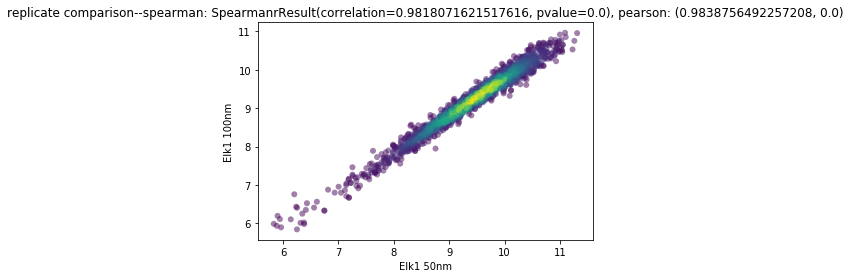

In [7]:
xy = np.vstack([xvals1,xvals2])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals1, xvals2, c=z, edgecolor='', alpha=0.5)
plt.xlabel("Elk1 50nm")
plt.ylabel("Elk1 100nm")
plt.title("replicate comparison--spearman: "+ \
          str(spearmanr(xvals1, xvals2)) + ", pearson: "+ str(pearsonr(xvals1, xvals2)))
plt.show()

In [8]:
os.environ["CUDA_VISIBLE_DEVICES"]="0, 2"
def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tfp.distributions.Multinomial(total_count=counts_per_example,
                                         logits=logits)
    return (-tf.reduce_sum(dist.log_prob(true_counts)) / 
            tf.to_float(tf.shape(true_counts)[0]))

#from https://github.com/kundajelab/basepair/blob/cda0875571066343cdf90aed031f7c51714d991a/basepair/losses.py#L87
class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

In [9]:
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL,'RevCompConv1D': RevCompConv1D}):
    model = load_model("../data/models/gm12878_elk1_model.h5")







Instructions for updating:
Use `tf.cast` instead.


In [10]:
fastapath = "../data/genome/hg19/male.hg19.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

seq_len = 1346
out_pred_len = 1000
test_chrms = ["chr1", "chr8", "chr21"]
seq_peaks = []
with gzip.open("../data/paralogous/GM12878_elk1/idr.optimal_peak.narrowPeak.gz", 'rt') as inp:
    for line in inp:
        chrm = line.strip().split('\t')[0]
        if chrm not in test_chrms:
            continue
        pStart = int(line.strip().split('\t')[1])
        summit = pStart + int(line.strip().split('\t')[-1])
        start = int(summit - (seq_len/2))
        end = int(summit + (seq_len/2))
        seq_peaks.append(GenomeDict[chrm][start:end].upper())
    
ltrdict = {
           'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1],
           'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],
           'T':[0,0,0,1],'N':[0,0,0,0]}
def getOneHot(ISM_sequences):
  # takes in list of sequences
    one_hot_seqs = []
    for seq in ISM_sequences:
        one_hot = []
        for i in range(len(seq)):
            one_hot.append(ltrdict[seq[i:i+1]])
        one_hot_seqs.append(one_hot)
    return np.array(one_hot_seqs)

In [11]:
def fill_into_center(seq, insert):
    pos = int((len(seq)-len(insert))/2.0)
    new_seq = seq[:pos] + insert + seq[pos+len(insert):]
    return new_seq

In [12]:
from deeplift.dinuc_shuffle import dinuc_shuffle

num_samples = 100
yvals = []
yvals_counts = []
for idx, insert in enumerate(seqs):
    if idx % 200 == 0:
        print("Done with ", idx)
    pre_seqs = []
    post_seqs = []
    indices = np.random.choice(len(seq_peaks), num_samples, replace=False)
    for idx in indices:
        pre_seq = dinuc_shuffle(seq_peaks[idx])
        post_seq = fill_into_center(pre_seq, insert)
        pre_seqs.append(pre_seq)
        post_seqs.append(post_seq)
    pre = model.predict([getOneHot(pre_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    post = model.predict([getOneHot(post_seqs), np.zeros((num_samples,)), np.zeros((num_samples,out_pred_len,2))])
    yvals.append(np.mean(post[0]-pre[0]))
    yvals_counts.append(np.mean(np.exp(post[0])-np.exp(pre[0])))

Done with  0
Done with  200
Done with  400
Done with  600
Done with  800
Done with  1000
Done with  1200
Done with  1400
Done with  1600
Done with  1800


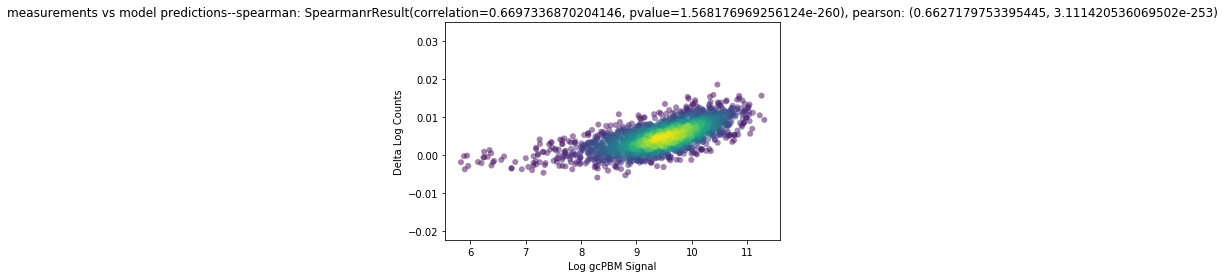

In [13]:
xy = np.vstack([xvals1,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals1, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("Log gcPBM Signal")
plt.ylabel("Delta Log Counts")
plt.title("measurements vs model predictions--spearman: "+ \
          str(spearmanr(xvals1, yvals)) + ", pearson: "+ str(pearsonr(xvals1, yvals)))
plt.show()

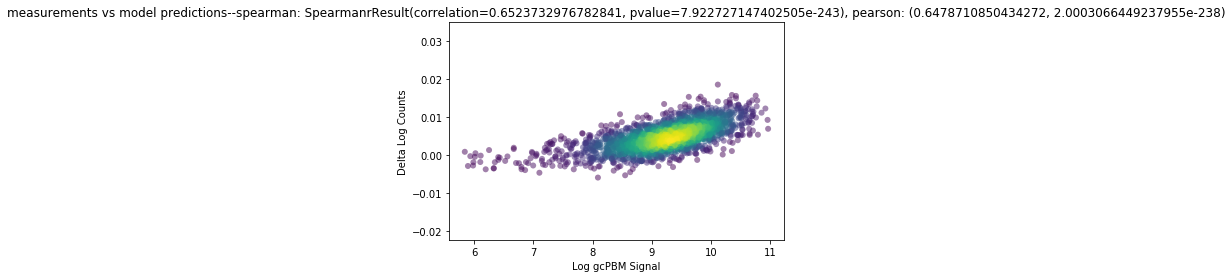

In [14]:
xy = np.vstack([xvals2,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals2, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("Log gcPBM Signal")
plt.ylabel("Delta Log Counts")
plt.title("measurements vs model predictions--spearman: "+ \
          str(spearmanr(xvals2, yvals)) + ", pearson: "+ str(pearsonr(xvals2, yvals)))
plt.show()

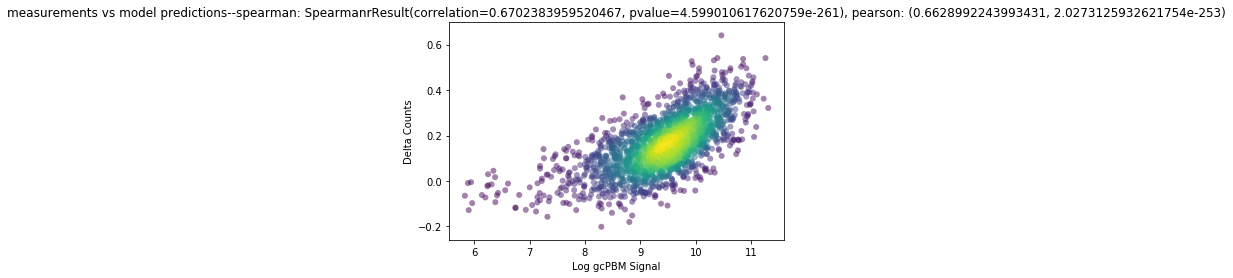

In [15]:
xy = np.vstack([xvals1,yvals_counts])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals1, yvals_counts, c=z, edgecolor='', alpha=0.5)
plt.xlabel("Log gcPBM Signal")
plt.ylabel("Delta Counts")
plt.title("measurements vs model predictions--spearman: "+ \
          str(spearmanr(xvals1, yvals_counts)) + ", pearson: "+ str(pearsonr(xvals1, yvals_counts)))
plt.show()

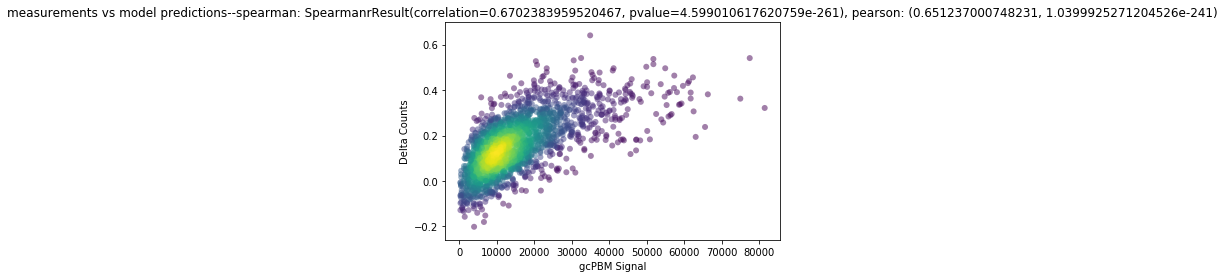

In [16]:
xvals_exp = np.exp(xvals1)
xy = np.vstack([xvals_exp,yvals_counts])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals_exp, yvals_counts, c=z, edgecolor='', alpha=0.5)
plt.xlabel("gcPBM Signal")
plt.ylabel("Delta Counts")
plt.title("measurements vs model predictions--spearman: "+ \
          str(spearmanr(xvals_exp, yvals_counts)) + ", pearson: "+ str(pearsonr(xvals_exp, yvals_counts)))
plt.show()

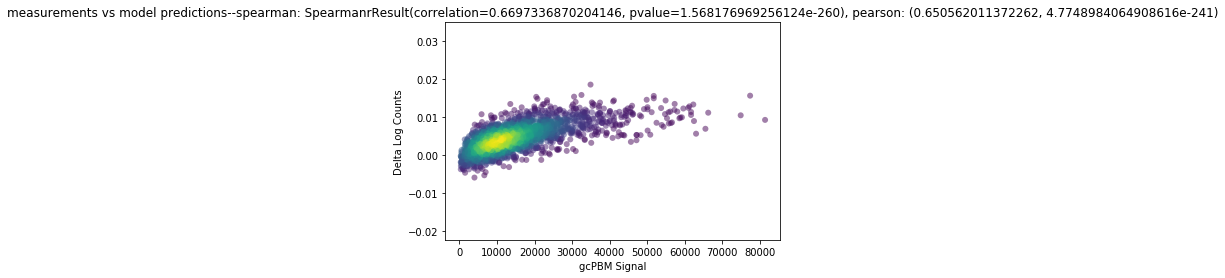

In [17]:
xvals_exp = np.exp(xvals1)
xy = np.vstack([xvals_exp,yvals])
z = gaussian_kde(xy)(xy)
smallFont = {'size' : 10}
plt.rc('font', **smallFont)
fig, ax = plt.subplots()
ax.scatter(xvals_exp, yvals, c=z, edgecolor='', alpha=0.5)
plt.xlabel("gcPBM Signal")
plt.ylabel("Delta Log Counts")
plt.title("measurements vs model predictions--spearman: "+ \
          str(spearmanr(xvals_exp, yvals)) + ", pearson: "+ str(pearsonr(xvals_exp, yvals)))
plt.show()